### Process:
1. Ensure that we are trading every hour
2. Get live data (3 Data points to account for the data preparation)
3. Append it to csv, ensuring the limit of data points in the csv file (the limit == the train_size for the optimization process)
4. Load the data from the csv file
5. optimize if time to optimize (use optimize_counter)
6. rebalance if time to rebalance (use rebalance_counter)
7. Run the strategy on the dataset
8. On the last time index (the last candle), get the universe (level 2 index) and actual allocation for each coin\
=> Make sure that we have applied self.live = True when initiating the strategy (to not shift the position values)\
(a) If coin not in universe -> Put their allocation\
(b) If actual allocation != shifted allocation, change the allocation of the coin\
--> Changing the allocation of a coin, is by determining the amount in currency = (amount_USD / close_price) to sell or to buy, then placing that order
---
# Strategy Optimization and Portfolio Management

---

## At Boot

1. Get all symbols.
2. Fetch `market_data` (up-to-date data) and trim it to `train_size + test_size` (assuming a constant `step_size` equal to `train_size`).
3. Format symbols to match the exchange (e.g., Kraken).
4. Use `symbols` to get halal data.
5. Save `market_data` to `market_data.csv`.
6. Initialize the `strategy_instances` map (add all strategies into a dictionary).

---

## **For Strategy Optimization**

### When Optimizing

1. Run strategy optimization (not walk-forward optimization) for each strategy to determine `best_params`.
2. Store `best_params` for each strategy in a dictionary for later use.
3. Run each strategy with its `best_params`.

---

## **For Portfolio Management**

### When Optimizing

1. Perform the walk-forward optimization (WFO) process for each strategy using all `market_data` to get results for each strategy.
2. Extract `strategy_returns` from the WFO results for each strategy.
3. Set the `max_allocation` parameter to 1.
4. Run portfolio management on `strategy_returns` to create a new map of selected strategies (on each optimization).
5. Store the `selected_strategy_map` for later use.

---

## **For Portfolio Optimization**

### When Rebalancing

1. Run the WFO process for each selected strategy using all `market_data` to obtain results.
2. Perform portfolio optimization on `strategy_returns` to calculate weights:
   - Use `max_allocation` based on `current_total_balance * weight`.

---

## **For Portfolio Risk Management**

### At Each Time We Loop

1. Run each strategy with its `best_params` on `market_data.csv`:
   - Set `max_allocation = max_allocation / max_positions * current_total_balance * according_weight`.
2. Obtain `strategy_returns` and their weights.
3. Run `calculate_returns()` from portfolio optimization to output `weighted_returns`.
4. Calculate cumulative return (`current_portfolio_returns`) from `weighted_returns`.
5. Perform portfolio risk management on `current_portfolio_returns`:
   - If `True` in the last row of `portfolio_rm`:
     - Check if holding any coins:
       - Liquidate all coins in the portfolio balance.
     - Continue.
   - If `False`, do nothing.

---

## **Taking Positions**

### At Each Time We Loop

1. Update the strategy map with the `max_allocation` for each strategy instance.
2. Fetch the `current_total_balance` of the portfolio from the exchange.
3. Get the latest data using `symbols` and append to `market_data.csv`.
4. Ensure `market_data` length equals `train_size + test_size`.
5. Run each strategy with `best_params` on `market_data.csv`:
   - Update `max_allocation = max_allocation / max_positions * current_total_balance * according_weight`.
6. Obtain the DataFrame for each strategy.
7. Concatenate all strategies' data (`index['coin']`, `current_allocation`).
8. Calculate allocation per coin (as a dictionary mapping allocations to names).
9. Identify `current_universe` (using the last row of `df_strategies`).
10. Determine `current_allocation_coin_currency` for each coin:
    - `df_strategies['current_allocation'] / df_strategies['close']`.
11. Identify `current_held_coin` from the portfolio.
12. Liquidate all coins not in the `current_universe`.
13. For each coin:
    - Fetch its current balance and actual allocation from `df_strategies`.
    - Calculate `position_to_add`.
    - If `position_to_add > 0`, execute a buy signal; otherwise, execute a sell signal.

---

## **Combining Processes**

Processes occurring simultaneously can be combined under a single method to avoid redundancy.

---

## **Initialization Variables**

- `strat_1_instance = ...`
- `strat_2_instance = ...`
- `counter = 0`
- `cash_df = ...`
- `strategy_map = {}`
- `best_params = None`
- `best_weights = None`
- `exchange = ...`
- `symbols = ...`
- `symbols_to_liquidate = None`
- `selected_strategy = None`
- `drawdown_threshold = -0.15`
- `train_size = 440`
- `test_size = 200`
- `step_size = 200`
- `low_corr_thresh = 1`
- `strategy_data_filename = 'strategy_data.csv'`
- `market_data_filename = 'market_data.csv'`
- `max_rows_market_data = market_data_size = 2000`
- `timeframe = '1h'`
- `strategy_optimization_frequency = step_size`
- `portfolio_optimization_frequency = 300`
- `portfolio_management_frequency = 4380` (Every 6 months)

---

## **Execution**

### Before the Main Loop

1. Load `market_data.csv`.

### Main Loop

At the beginning of each hour:
1. Perform optimization: `perform_optimization()`.
2. Perform portfolio optimization: `perform_portfolio_optimization()`.
3. Perform portfolio management: `perform_portfolio_management()`.
4. Perform portfolio risk management: `perform_portfolio_rm()`:
   - Continue if it outputs `True` (indicating a drawdown).
5. Execute strategies: `run_strategy()`.

In [ ]:
def symbols_in_current_balance(exchange):
    # Fetch account balance
    try:
        balance = exchange.fetch_balance()
        
        # Extract symbols with non-zero balance
        symbols = [currency + 'USDT' for currency, info in balance['total'].items() if info > 0]
        
        print("Symbols in your current balance:", symbols)
    except ccxt.BaseError as e:
        print(f"An error occurred: {e}")
def buy(to_add, coin, exchange):
    try:
        order = exchange.create_market_buy_order(coin, to_add)
        print(f"Buy order placed: {order}")
    except Exception as e:
        print(f"Error: {e}")
def sell(to_sell, coin, exchange):
    try:
        order = exchange.create_market_sell_order(coin, to_sell)
        print(f"Sell order placed: {order}")
    except Exception as e:
        print(f"Error: {e}")
def liquidate(exchange):
    try:
        # Step 1: Get your balances
        balance = exchange.fetch_balance()
        cant_liquidate = ['USD', 'CAD']

        # Step 2: Loop through all assets in your balance and sell them
        for coin, coin_balance in balance['free'].items():
            if coin not in cant_liquidate:
                if coin_balance > 0:  # Only sell if you have a non-zero balance
                    print(f"Selling {coin_balance} {coin}...")

                    # Determine the symbol for the sell order (e.g., BTC/USD, ETH/USDT)
                    symbol = f"{coin}/USD"  # Replace USD with your preferred quote currency
                    order = exchange.create_market_sell_order(symbol, coin_balance)
                    print(f"Sell order placed: {order}")
                else:
                    print(f"No {coin} to sell.")

        print("All possible assets have been liquidated.")

    except Exception as e:
        print(f"Error: {e}")
import ccxt
import pandas as pd
import numpy as np
import os
import time
from unsync import unsync
import datetime as dt
import sys
from concurrent.futures import ThreadPoolExecutor
import re
import warnings
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
# Ensure the directories are in the system path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'Data_Management'))) 
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'Portfolio_Optimization'))) 
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'Strategies', 'Trend_Following')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'Strategies', 'Mean_Reversion')))

# Import the modules
from data import Data, get_symbols_for_bot
from fetch_symbols import get_symbols
from sprtrnd_breakout import Sprtrnd_Breakout
from last_days_low import Last_Days_Low
from portfolio_management import Portfolio_Management
from portfolio_optimization import Portfolio_Optimization
from portfolio_risk_management import Portfolio_RM

### At boot
symbols = get_symbols_for_bot()
#Connect to exchange
api_key = 'yqPWrtVuElaIExKmIp/E/upTOz/to1x7tC3JoFUxoSTKWCOorT6ifF/B'
api_secret = 'L8h5vYoAu/jpQiBROA9yKN41FGwZAGGVF3nfrC5f5EiaoF7VksruPVdD7x1VOwnyyNCMdrGnT8lP4xHTiBrYMQ=='

exchange = ccxt.kraken({
    'apiKey': api_key,
    'secret': api_secret
})
all_symbols = get_symbols()
train_size = 500
test_size = 500
step_size = 500
start_time = (dt.datetime.now() - dt.timedelta(hours=train_size + test_size + 200)).date()
end_time = dt.datetime.now().date()
timeframes = ['1w', '1d', '4h', '1h', '30m','15m', '5m', '1m']
index = 3 #It is better to choose the highest frequency for the backtest to be able to downsample
interval = timeframes[index]
symbols = ['BTCUSD']
data_instance = Data(symbols, interval, start_time, end_time, exchange = 'kraken', get_data = False)
data = data_instance.get_data()
last_date_data = data.index.get_level_values(0).unique()[-1].tz_localize('UTC')
if dt.datetime.now(dt.UTC).replace(minute=0, second=0, microsecond=0) != last_date_data:
    time_difference = dt.datetime.now(dt.UTC).replace(minute=0, second=0, microsecond=0) - last_date_data
    hours_difference = time_difference.total_seconds() / 3600 # Get the number of hours
    missing_data = fetch_latest_data(all_symbols, interval, limit = int(hours_difference) + 1).result()
    complete_data = pd.concat([data, missing_data])
complete_data.index = complete_data.index.set_levels(pd.to_datetime(complete_data.index.levels[0]), level=0)
complete_data.to_csv('market_data.csv')
Putting all together
def complete_missing_data(data):
    if dt.datetime.now(dt.UTC).replace(minute=0, second=0, microsecond=0) != last_date_data:
        time_difference = dt.datetime.now(dt.UTC).replace(minute=0, second=0, microsecond=0) - last_date_data
        hours_difference = time_difference.total_seconds() / 3600 # Get the number of hours
        missing_data = fetch_latest_data(symbols, interval, limit = int(hours_difference) + 1).result()
        complete_data = pd.concat([data, missing_data])
        
    complete_data.index = complete_data.index.set_levels(pd.to_datetime(complete_data.index.levels[0]), level=0)
    complete_data.to_csv('market_data.csv')
    print('Market data updated successfully')
def upload_complete_market_data(symbols, data_size = 2200):
    start_time = (dt.datetime.now() - dt.timedelta(hours= data_size)).date()
    end_time = dt.datetime.now().date()
    timeframes = ['1w', '1d', '4h', '1h', '30m','15m', '5m', '1m']
    index = 3 #It is better to choose the highest frequency for the backtest to be able to downsample
    interval = timeframes[index]
    data_instance = Data(symbols, interval, start_time, end_time, exchange = 'kraken')
    data = data_instance.df
    last_date_data = data.index.get_level_values(0).unique()[-1].tz_localize('UTC')
upload_complete_market_data(symbols, data_size = (train_size + test_size) * 1)
### At each time we loop
data.index.get_level_values("date").unique()[-1]
dt.datetime.now(dt.UTC).date() == data.index.get_level_values("date").unique()[-1].date()
#Helper function
def get_last_row(data, check_todays_date = False):
    """Get the last date in the dataset."""
    if check_todays_date:
        last_date = data.index.get_level_values("date").unique()[-1]
        if last_date.date() == dt.datetime.now(dt.UTC).date():
            return data.loc[last_date]
        else:
            return None
def get_portfolio_value(exchange):
    try:
        # Fetch account balances
        balances = exchange.fetch_balance()

        # Fetch tickers to get the latest prices
        tickers = exchange.fetch_tickers()

        # Calculate portfolio value in USD (or another base currency)
        portfolio_value = 0.0

        for currency, balance in balances['total'].items():
            if balance > 0:
                if currency == "USD":
                    # Add USD cash directly to portfolio value
                    portfolio_value += balance
                else:
                    # Use the USD pair or the most liquid market
                    pair = f"{currency}/USD"
                    if pair in tickers:
                        price = tickers[pair]['last']
                        portfolio_value += balance * price
                    else:
                        # Handle currencies without USD pairs (e.g., trade to BTC, then USD)
                        btc_pair = f"{currency}/BTC"
                        if btc_pair in tickers:
                            btc_price = tickers[btc_pair]['last']
                            usd_price = tickers["BTC/USD"]['last']
                            portfolio_value += balance * btc_price * usd_price

        return round(portfolio_value, 2)

    except ccxt.BaseError as e:
        print(f"An error occurred: {str(e)}")
        return None

portfolio_value = get_portfolio_value(exchange)
portfolio_value
def format_symbols(symbols):
    """Converts the symbols to a format that the exchange understands."""
    if symbols[0].endswith('T'):
        symbols = [s[:-1] for s in symbols]
    formatted_symbols = [symbol.replace("USD", "/USD") for symbol in symbols]
    return formatted_symbols

def filter_halal_df(data):
    # Drop multiple coins
    symbols = ['BTC/USD', 'ETH/USD', 'LTC/USD']
    data_filtered = data[data.index.get_level_values("coin").isin(symbols)]
    return data_filtered
symbols = get_symbols_for_bot()
formatted_symbols = format_symbols(symbols)
@unsync
def fetch_latest_data(symbols, timeframe, limit=2):
    """Fetch latest OHLCV data for multiple symbols and stack them into a single DataFrame."""
    
    formatted_symbols = format_symbols(symbols)
    
    def fetch_symbol_data(symbol, formatted_symbol):
        """Fetch data for a single symbol and return a DataFrame."""
        try:
            ohlcv = exchange.fetch_ohlcv(formatted_symbol, timeframe, limit=limit)
            df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
            df.set_index('timestamp', inplace=True)
            df['coin'] = formatted_symbol
            return df
        except Exception as e:
            print(f"Error fetching data for {symbol}: {e}")
            try:
                # Retry fetching data
                ohlcv = exchange.fetch_ohlcv(symbol, timeframe, limit=limit)
                df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
                df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
                df.set_index('timestamp', inplace=True)
                df['coin'] = formatted_symbol
                return df
            except Exception as e:
                print(f"Error fetching data for {symbol} on retry: {e}")
                return pd.DataFrame()

    # Use ThreadPoolExecutor for parallel requests
    with ThreadPoolExecutor(max_workers=16) as executor:  # Adjust workers based on CPU
        results = list(executor.map(fetch_symbol_data, symbols, formatted_symbols))

    # Concatenate all DataFrames and set multi-level index
    data_frames = [df for df in results if not df.empty]
    if data_frames:
        stacked_df = pd.concat(data_frames)
        stacked_df.set_index('coin', append=True, inplace=True)
        stacked_df = stacked_df[~stacked_df.index.duplicated()]  # Remove duplicates
        df = data_instance.prepare_data(stacked_df.unstack())
        df.reset_index(level = 1, inplace = True)
        df['coin'] = df['coin'].str.replace('/USD', 'USDT', regex=False)
        df.set_index('coin', append = True, inplace = True)
        return df
    else:
        return pd.DataFrame()  # Return an empty DataFrame if no data
# Example usage
timeframe = '1h'
latest = fetch_latest_data(symbols, timeframe).result()
latest
# Append new data to CSV and maintain max length (asynchronous)
@unsync
def append_to_csv_with_limit(data, filename, max_rows=2202):
    """_summary_

    Args:
        data (_type_): _description_
        filename (_type_): _description_
        max_rows (int, optional): _description_. Defaults to 2202. Should be account for the max number of rows needed for any of the processes
    """
    file_exists = os.path.isfile(filename)
    df = pd.DataFrame(data)
    
    if file_exists:
        existing_df = pd.read_csv(filename, index_col=[0, 1], parse_dates=['date'])
        print(df.index.get_level_values(0).unique()[-1], existing_df.index.get_level_values(0).unique()[-1])
        if existing_df.index.get_level_values(0).unique()[-1] == latest.index.get_level_values(0).unique()[-1]:
            return
        combined_df = pd.concat([existing_df, df])
        if len(combined_df) > max_rows:
            combined_df = combined_df.iloc[-max_rows:]  # Keep only the last max_rows rows
        combined_df.to_csv(filename)
    else:
        print('File does not exist')
        df.to_csv(filename, mode='w', header=True)

append_to_csv_with_limit(latest, 'market_data.csv', max_rows= (test_size + train_size) * 4).result()
#Getting the data from csv
def load_data_from_csv(filename, train_size = 500, test_size = 500):
    if os.path.isfile(filename):
        data = pd.read_csv(filename, index_col=['date', 'coin'], parse_dates=['date'])
        if len(data) >= train_size + test_size:
            return data
        else:
            print('Data is not enough')
            return pd.DataFrame()
    else:
        print('File does not exist')
        return pd.DataFrame()
data = load_data_from_csv('market_data.csv')
data
### Portfolio Management
Should be ran every time we want to optimize
train_size = 500
test_size = 500
step_size = 500
mr_strat_1 = Last_Days_Low(data, objective = 'multiple', train_size = train_size, test_size = test_size, step_size = step_size)
tf_strat_1 = Sprtrnd_Breakout(data, objective = 'multiple', train_size = train_size, test_size = test_size, step_size = step_size)

#Create a dummy results that represents holding cash where the value of the portfolio is constant
cash_df = pd.DataFrame(data = {'strategy': np.zeros(data.shape[0]), 'portfolio_value': np.ones(data.shape[0])}, index = data.index)

strategy_map = {'cash_strat': cash_df,
                'mr_strat_1': mr_strat_1,
                'tf_strat_1': tf_strat_1}
mr_strat_1.optimize()
mr_strat_1.test()
mr_strat_1.results.cstrategy.plot()
tf_strat_1.test()
tf_strat_1.results.cstrategy.plot()
#Run the WFO for each strategy (but the cash strategy)
for key, value in strategy_map.items():
    if key != 'cash_strat':
        print(key)
#Run the WFO for each strategy (but the cash strategy)
for key, value in strategy_map.items():
    if key != 'cash_strat':
        value.test()
#Make a new dictionary that contains the results strategy returns of the WFO
results_strategy_returns = {}
for key, value in strategy_map.items():
    if key != 'cash_strat':
        results_strategy_returns[key] = value.results.strategy
    elif key == 'cash_strat':
        results_strategy_returns[key] = value.strategy
portfolio_management = Portfolio_Management(results_strategy_returns)
keys_for_selected_strategy = portfolio_management.filter_by_correlation(low_corr_threshold=1).columns
selected_strategy = {key: value for key, value in strategy_map.items() if key in keys_for_selected_strategy}
Putting All together
def run_wfo_and_get_results_returns(strategy_map):
    """_summary_
    Takes the strategy map, runs the WFO for each strategy and returns the results of the strategy returns after the WFO.
    It also adds the df of the strategy returns to a csv file

    Args:
        strategy_map (_type_): _description_

    Returns:
        results_strategy_returns (_type_): _description_ the results of the strategy returns after the WFO
    """
    #Run the WFO for each strategy (but the cash strategy)
    for key, value in strategy_map.items():
        if key != 'cash_strat':
            value.test()
            
    #Make a new dictionary that contains the results strategy returns of the WFO
    results_strategy_returns = {}
    for key, value in strategy_map.items():
        if key != 'cash_strat':
            results_strategy_returns[key] = value.results.strategy
        elif key == 'cash_strat':
            results_strategy_returns[key] = value.strategy
            
    #Get the strategy returns df
    strategy_returns_df = pd.concat(results_strategy_returns, axis = 1).fillna(0)
    strategy_returns_df.to_csv('strategy_returns.csv')
    
    return results_strategy_returns
def perform_portfolio_management(strategy_map, low_corr_threshold = 1):
    """_summary_

    Args:
        strategy_map (_type_): _description_
        low_corr_threshold (int, optional): _description_. Defaults to 1.
    """
    results_strategy_returns = run_wfo_and_get_results_returns(strategy_map)

    portfolio_management = Portfolio_Management(results_strategy_returns)

    keys_for_selected_strategy = portfolio_management.filter_by_correlation(low_corr_threshold=low_corr_threshold).columns

    selected_strategy = {key: value for key, value in strategy_map.items() if key in keys_for_selected_strategy}

    return selected_strategy
selected_strategy = perform_portfolio_management(strategy_map)
### Strategy Optimization
counter_opt = 0
counter_reb = 0
#Run the optimization to get the strategy parameters
for key, value in strategy_map.items():
    if key != 'cash_strat':
        value.optimize()
#Storing the best_params for each strategy in a separate dictionary
best_params = {key: value.best_params for key, value in strategy_map.items() if key != 'cash_strat'}
best_params
Putting all together
counter_opt = 0
counter_reb = 0 
def perform_optimization(strategy_map):
    """_summary_

    Args:
        strategy_map (_type_): _description_
    """

    #Run the optimization to get the strategy parameters
    for key, value in strategy_map.items():
        if key != 'cash_strat':
            value.optimize()

    #Storing the best_params for each strategy in a separate dictionary
    best_params = {key: value.best_params for key, value in strategy_map.items() if key != 'cash_strat'}

    return best_params
data
best_params = perform_optimization(strategy_map)
### Portfolio Optimization
#Run the WFO for each strategy (but the cash strategy)
for key, value in strategy_map.items():
    if key != 'cash_strat':
        value.test()
#Make a new dictionary that contains the results strategy returns of the WFO
results_strategy_returns = {}
for key, value in strategy_map.items():
    if key != 'cash_strat':
        results_strategy_returns[key] = value.results.strategy
    elif key == 'cash_strat':
        results_strategy_returns[key] = value.strategy
#Get the strategy returns df
strategy_returns_df = pd.concat(results_strategy_returns, axis = 1).fillna(0)
strategy_returns_df
if step_size + train_size + test_size > len(results_strategy_returns):
    raise ValueError("Invalid train, test, or step size.")
#Get portfolio optimization instance
portfolio_optimization_instance = Portfolio_Optimization(log_rets = results_strategy_returns, train_size = 200, test_size = 200, step_size = 200, objective = 'multiple')
#Run the optimization
train_data = strategy_returns_df.iloc[-train_size:]
train_data
best_weights = portfolio_optimization_instance.optimize_weights_minimize(train_data)
best_weights
Putting all together

def perform_portfolio_optimization(strategy_map, train_size = 1000, test_size = 1000, step_size = 1000):
    """_summary_

    Args:
        strategy_returns_df (_type_): _description_
        train_size (int, optional): _description_. Defaults to 1000.
        test_size (int, optional): _description_. Defaults to 1000.
        step_size (int, optional): _description_. Defaults to 1000.
    """
    results_strategy_returns = run_wfo_and_get_results_returns(strategy_map)
    
    #Get portfolio optimization instance
    portfolio_optimization_instance = Portfolio_Optimization(log_rets = results_strategy_returns, train_size = train_size, test_size = test_size, step_size = step_size, objective = 'multiple')\

    #Run the optimization
    results_strategy_returns_df = pd.concat(results_strategy_returns, axis = 1).fillna(0)
    train_data = results_strategy_returns_df.iloc[-train_size:]
    best_weights = portfolio_optimization_instance.optimize_weights_minimize(train_data)

    return best_weights
best_weights = perform_portfolio_optimization(strategy_map, train_size, test_size, step_size)
### Portfolio Risk Management
#Get the current_total_balance
current_total_balance = get_portfolio_value(exchange)
current_total_balance
best_params = {'mr_strat_1':{'std_window': 23, 'mean_window': 8, 'ema_window': 47, 'hourly_lookback': 2, 'daily_lookback': 5, '_min_pos': 0.3565276673865839, '_max_pos': 0.8449133579645757, 'sl_ind_length': 36, 'sl_ind_mult': 1.1269915448264407, 'tp_mult': 5, 'ptp_mult': 1.5398410913016733, 'ptp_exit_percent': 0.2827551022612925},
    'tf_strat_1':  {'std_window': 7, 'mean_window': 20, 'ema_window': 41, 'str_length': 49, 'str_mult': 3, '_min_pos': 0.6449553050522405, '_max_pos': 1.0204613078816698, 'sl_ind_length': 25, 'sl_ind_mult': 0.5596923252193994, 'tp_mult': 7, 'ptp_mult': 1.5632882178455394, 'ptp_exit_percent': 0.4468748522859246}}
best_weights = [0, 0.5, 0.5]
#Store the max allocation for each strategy in a dictionary
max_allocation_map = {
    key: best_weights[i] * current_total_balance / strategy.max_universe
    for i, (key, strategy) in enumerate(strategy_map.items())
    if i < len(best_weights) and best_weights[i] > 0 and key != 'cash_strat'
}

max_allocation_map
#Rebuild the strategy map, with the updated max_allocation for each strategy
for key, value in strategy_map.items():
    if key != 'cash_strat':
        value.max_dollar_allocation = max_allocation_map[key]
step_size = 500
trading_strat_data = mr_strat_1.trading_strategy(data, best_params['mr_strat_1'])
trading_strat_data
len(trading_strat_data)
trading_strat_data_2 = tf_strat_1.trading_strategy(data, best_params['tf_strat_1'])
trading_strat_data_2
len(trading_strat_data_2)
#Run each strategy on enough data points and get the total portfolio value
length_of_data_to_run_strategy = 2000 #This is because we are going to be using the parameters that were optimized on the last step
    #And thus taking into account the data with the same parameters of a previoused optimized period would be incorrect because markets may have changed
data_to_run_strategy = data.iloc[-length_of_data_to_run_strategy:]

current_strategy_returns = {
    key: value.trading_strategy(data, best_params[key])['strategy']
    for key, value in strategy_map.items()
    if key != 'cash_strat'
}
current_strategy_returns['cash_strat'] = cash_df['strategy']
current_strategy_returns_df = pd.concat(current_strategy_returns, axis = 1).fillna(0)

current_strategy_returns_df.to_csv('strategy_returns.csv')

pd.read_csv('strategy_returns.csv', index_col= [0, 1], parse_dates = ['date'])
portfolio_returns = np.dot(best_weights, current_strategy_returns_df.T)
portfolio_returns_series = pd.Series(portfolio_returns)
portfolio_returns_series.cumsum().apply(np.exp).plot()
portfolio_rm_instance = Portfolio_RM(portfolio_returns_series)
drawdown_limit, in_drawdown = portfolio_rm_instance.drawdown_limit(-0.15)
in_drawdown
if in_drawdown.iloc[-1]:
    #Liquidate the portfolio
    symbols_to_liquidate = current_strategy_returns_df.index.get_level_values(1).unique()[-1]
    liquidate(symbols_to_liquidate, exchange)
    #return True
Putting all_together
def perform_portfolio_rm(best_weights, exchange, drawdown_threshold = -0.15):
    """_summary_"""
    current_strategy_returns_df = pd.read_csv('strategy_returns.csv', index_col= [0, 1], parse_dates = ['date'])

    portfolio_returns = np.dot(best_weights, current_strategy_returns_df.T)
    portfolio_returns_series = pd.Series(portfolio_returns)

    portfolio_rm_instance = Portfolio_RM(portfolio_returns_series)

    drawdown_limit, in_drawdown = portfolio_rm_instance.drawdown_limit(drawdown_threshold)

    if in_drawdown.iloc[-1]:
        #Liquidate the portfolio
        print(f'Liquidating the portfolio because in_drawdown in {in_drawdown.iloc[-1]}')
        symbols_to_liquidate = symbols_in_current_balance(exchange)
        liquidate(symbols_to_liquidate, exchange)
        return True
    else :
        print(f'Portfolio is not in drawdown because in drawdown is {in_drawdown.iloc[-1]}')
        return False
perform_portfolio_rm(best_weights, exchange)
### Taking Positions
#Get the current_total_balance
current_total_balance = get_portfolio_value(exchange)
current_total_balance
best_weights
best_weights = [0.34, 0.33, 0.33]
#Store the max allocation for each strategy in a dictionary
max_allocation_map = {
    key: best_weights[i] * current_total_balance / strategy.max_universe
    for i, (key, strategy) in enumerate(strategy_map.items())
    if i < len(best_weights) and best_weights[i] > 0 and key != 'cash_strat'
}

max_allocation_map
#Rebuild the strategy map, with the updated max_allocation for each strategy
for key, value in strategy_map.items():
    if key != 'cash_strat':
        value.max_dollar_allocation = max_allocation_map[key]
sample_results = tf_strat_1.trading_strategy(data, best_params['tf_strat_1'])
sample_results
timeframe = '1h'
symbols = ['BTCUSD', 'ETHUSD']
latest = fetch_latest_data(symbols, timeframe).result()
latest
append_to_csv_with_limit(latest, 'market_data.csv').result()
data = load_data_from_csv('market_data.csv')
data
#Run each strategy on enough data points and get the total portfolio value
length_of_data_to_run_strategy = 1000 #This does not have to do with anything with test_size or train_size,
    #but it is better to be equal to the test_size because we want get the latest returns of the strategy with the latest best_params to get the current strategy returns
data_to_run_strategy = data.iloc[-length_of_data_to_run_strategy:]
best_params = {'tf_strat_1': {'std_window': 5, 'mean_window': 10, 'ema_window': 73, 'str_length': 41, 'str_mult': 3, '_min_pos': 0.6947256588850119, '_max_pos': 0.9766155382529169, 'sl_ind_length': 46, 'sl_ind_mult': 4.325173600054098, 'tp_mult': 4, 'ptp_mult': 1.0954101164904113, 'ptp_exit_percent': 0.43373642697843984},
    'mr_strat_1': {'std_window': 5, 'mean_window': 10, 'ema_window': 73, 'hourly_lookback': 1, 'daily_lookback': 3, '_min_pos': 0.6947256588850119, '_max_pos': 0.9766155382529169, 'sl_ind_length': 46, 'sl_ind_mult': 4.325173600054098, 'tp_mult': 4, 'ptp_mult': 1.0954101164904113, 'ptp_exit_percent': 0.43373642697843984},}
current_strategy_results = {
    key: value.trading_strategy(data_to_run_strategy, best_params[key])
    for key, value in strategy_map.items()
    if key != 'cash_strat'
}
current_allocation_strategy_map = {
    key: value["coin_amount_to_bought"]
    for key, value in current_strategy_results.items()
    if key != "cash_df"
}
current_allocation_strategy_map['tf_strat_1']
current_allocation_results_df = pd.concat(current_allocation_strategy_map, axis=1).fillna(0).sum(axis=1).sort_index()
current_allocation_results_df.loc[current_allocation_results_df.index.get_level_values(0).unique()[-1]]
current_allocation_results_df.index.get_level_values(0).unique()[-1]
current_allocation = current_allocation_results_df.loc[current_allocation_results_df.index.get_level_values("date").unique()[-1]]
pd.DataFrame(current_allocation).set_index
last_index = [current_allocation_results_df.index.get_level_values(0).unique()[-1]] * len(current_allocation)
current_allocation
current_allocation.index = pd.MultiIndex.from_tuples(zip(last_index, current_allocation.index), names = ['date', ''])
current_allocation
list(set(tf_strat_1.current_universe) set(mr_strat_1.current_universe))

# Extract current universes from selected_strategy
current_universes = [
    set(value.current_universe)  # Convert each universe to a set for comparison
    for key, value in selected_strategy.items()
    if key != 'cash_strat'
]

# Remove overlaps between universes
# Start with the first set and iteratively remove overlaps
unique_universes = []
for universe in current_universes:
    for other_universe in unique_universes:
        universe -= other_universe  # Remove overlapping strings
    unique_universes.append(universe)

# Convert sets back to lists (if needed)
unique_universes = [list(universe) for universe in unique_universes]

flattened_universe = [item for sublist in unique_universes for item in sublist]

flattened_universe
# This will be used to plot the current portfolio 
portfolio_returns = np.dot(best_weights, current_strategy_returns_df.T)
portfolio_cumulative_returns = pd.Series(portfolio_returns).cumsum().apply(np.exp)
portfolio_cumulative_returns.plot()
symbols_in_current_balance = symbols_in_current_balance(exchange)
symbols_in_current_balance
# Ensure symbols_in_current_balance is not None
if symbols_in_current_balance:
    symbols_not_in_universe = [
        symbol for symbol in symbols_in_current_balance
        if symbol not in flattened_universe
    ]
    # Liquidate the symbols not in the current universe
    liquidate(symbols_not_in_universe, exchange)
else:
    print("symbols_in_current_balance is None or empty.")

def get_coin_balance(coin):
    try:
        balance = exchange.fetch_balance()
        coin_balance = balance['total'][coin]
        return coin_balance
    except Exception as e:
        print(f"Error fetching balance for {coin}: {e}")
        return None
def get_coin_allocation(coin, current_allocation_latest_row):
    return current_allocation_latest_row[coin]
current_allocation['BTCUSDT']
for coin in flattened_universe:
    formatted_coin = coin.replace('USDT', '').replace('USD', '')
    coin_for_order = coin.replace('USDT', '/USD')

    coin_balance = get_coin_balance(formatted_coin)
    current_coin_allocation = current_allocation[coin]
    
    to_add = current_coin_allocation - coin_balance
    
    if to_add > 0:
        print(f"Adding {to_add} {formatted_coin} to the portfolio...")
        buy(to_add, coin_for_order, exchange)
    elif to_add < 0:
        print(f"Selling {-to_add} {formatted_coin} from the portfolio...")
        sell(-to_add, coin_for_order, exchange)
Putting Everything Together
def run_strategy(exchange, symbols, selected_strategy, best_params, best_weights, timeframe = '1h'):
    #Get the current_total_balance
    current_total_balance = get_portfolio_value(exchange)

    #Store the max allocation for each strategy in a dictionary
    max_allocation_map = {
        key: best_weights[i] * current_total_balance / strategy.max_universe
        for i, (key, strategy) in enumerate(selected_strategy.items())
        if i < len(best_weights) and best_weights[i] > 0 and key != 'cash_strat'
    }

    #Rebuild the strategy map, with the updated max_allocation for each strategy
    for key, value in selected_strategy.items():
        if key != 'cash_strat':
            value.max_dollar_allocation = max_allocation_map[key]
            
    
    timeframe = timeframe
    latest = fetch_latest_data(symbols, timeframe).result()
    append_to_csv_with_limit(latest, 'market_data.csv').result()
    data = load_data_from_csv('market_data.csv')
    
    
    #Run each strategy on enough data points and get the total portfolio value
    length_of_data_to_run_strategy = 100 #This does not have to do with anything with test_size or train_size,
        #but it is better to be equal to the test_size because we want get the latest returns of the strategy with the latest best_params to get the current strategy returns
    data_to_run_strategy = data.iloc[-length_of_data_to_run_strategy:]
    
    current_strategy_results = {
        key: value.trading_strategy(data_to_run_strategy, best_params[key])
        for key, value in selected_strategy.items()
        if key != 'cash_strat'
    }
    
    current_allocation_strategy_map = {
        key: value['current_allocation']
        for key, value in current_strategy_results.items()
        if key != 'cash_strat'
    }
    
    current_allocation_results_df = pd.concat(current_allocation_strategy_map, axis=1).fillna(0).sum(axis=1)
    
    current_allocation = get_last_row(current_allocation_results_df)
    
    current_universe = list(
        set(
            value.current_universe
            for value in selected_strategy.values()
            if key != 'cash_strat'
        )
    )

    symbols_in_current_balance = symbols_in_current_balance(exchange)
    # Find symbols in current balance but not in current universe
    symbols_not_in_universe = [symbol for symbol in symbols_in_current_balance if symbol not in current_universe]

    # Liquidate the symbols not in the current universe
    print(f"Liquidating {symbols_not_in_universe}...")
    liquidate(symbols_not_in_universe, exchange)
    print("Liquidation complete.")

    for coin in current_universe:
        formatted_coin = coin.replace('USDT', '')
        coin_balance = get_coin_balance(formatted_coin)
        current_coin_allocation = get_coin_allocation(coin, current_allocation)
        
        to_add = current_coin_allocation - coin_balance
        
        if to_add > 0:
            print(f"Adding {to_add} {formatted_coin} to the portfolio...")
            buy(to_add, coin, exchange)
        elif to_add < 0:
            print(f"Selling {-to_add} {formatted_coin} from the portfolio...")
            sell(-to_add, coin, exchange)
            
    # This will be used to plot the current portfolio 
    portfolio_returns = np.dot(best_weights, current_strategy_returns_df.T)
    portfolio_cumulative_returns = portfolio_returns.cumsum().apply(np.exp)
    portfolio_cumulative_returns.plot()
run_strategy(exchange, symbols, selected_strategy, best_params, best_weights, timeframe = '1h')
---
### Loop
# OUTSIDE OF METHOD:
upload_complete_market_data(symbols, data_size=(train_size + test_size) * 4)
strategy_data_filename = 'strategy_data.csv'
market_data_filename = 'market_data.csv'
data = load_data_from_csv(market_data_filename)
strat_1_instance = Last_Days_Low(data, objective='multiple', train_size=train_size, test_size=test_size, step_size=step_size)
strat_2_instance = Sprtrnd_Breakout(data, objective='multiple', train_size=train_size, test_size=test_size, step_size=step_size)

counter = 0
cash_df = pd.DataFrame(data={'strategy': np.zeros(data.shape[0]), 'portfolio_value': np.ones(data.shape[0])}, index=data.index)
strategy_map = {
    'cash_strat': cash_df,
    'strat_1': strat_1_instance,
    'strat_2': strat_2_instance
}
best_params = None
best_weights = None
exchange = ccxt.kraken({
    'apiKey': api_key,
    'secret': api_secret
})
symbols = ['BTCUSD', 'ETHUSD', 'LTCUSD']
symbols_to_liquidate = None
selected_strategy = None
drawdown_threshold = -0.15
train_size = 440
test_size = 200
step_size = 200
low_corr_thresh = 1.0
max_rows_market_data = market_data_size = 2000
timeframe = '1h'

strategy_optimization_frequency = 24  # Every 24 hours
portfolio_optimization_frequency = 24  # Every 24 hours
portfolio_management_frequency = 24  # Every 24 hours

# BEFORE THE MAIN LOOP
upload_complete_market_data(symbols, data_size=train_size + test_size)

# THE MAIN LOOP
while True:
    now = dt.datetime.now()
    next_hour = (now + dt.timedelta(minutes=1)).replace(second=0, microsecond=0)
    sleep_duration = (next_hour - now).total_seconds()
    time.sleep(sleep_duration)
    data = load_data_from_csv(market_data_filename)

    if counter % strategy_optimization_frequency == 0:
        best_params = perform_optimization(strategy_map)

    if counter % portfolio_optimization_frequency == 0:
        best_weights = perform_portfolio_optimization(strategy_map, train_size=train_size, test_size=test_size, step_size=step_size)

    if counter % portfolio_management_frequency == 0:
        selected_strategy = perform_portfolio_management(strategy_map, low_corr_threshold=low_corr_thresh)

    if perform_portfolio_rm(best_weights, exchange, drawdown_threshold=drawdown_threshold):
        continue

    run_strategy(exchange, symbols, selected_strategy, best_params, best_weights, timeframe=timeframe)
    
    counter += 1
Final Test


In [2]:
import ccxt
import pandas as pd
import numpy as np
import os
import time
from unsync import unsync
import datetime as dt
import sys
from concurrent.futures import ThreadPoolExecutor
import rich.live as Live
import rich.table as Table
import warnings
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
# Ensure the directories are in the system path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'Data_Management'))) 
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'Portfolio_Optimization'))) 
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'Strategies', 'Trend_Following')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'Strategies', 'Mean_Reversion')))

# Import the modules
from data import Data, get_symbols_for_bot
from fetch_symbols import get_symbols
from sprtrnd_breakout import Sprtrnd_Breakout
from last_days_low import Last_Days_Low
from portfolio_management import Portfolio_Management
from portfolio_optimization import Portfolio_Optimization
from portfolio_risk_management import Portfolio_RM

In [ ]:
import ccxt
import pandas as pd
import numpy as np
import os
import time
from unsync import unsync
import datetime as dt
import sys
from concurrent.futures import ThreadPoolExecutor
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

# sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..', 'Data_Management')))
# sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..', 'Portfolio_Optimization')))
# sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..', 'Strategies', 'Trend_Following')))
# sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..', 'Strategies', 'Mean_Reversion')))

# Import the modules
from data import Data, get_symbols_for_bot
from sprtrnd_breakout import Sprtrnd_Breakout
from last_days_low import Last_Days_Low
from portfolio_management import Portfolio_Management
from portfolio_optimization import Portfolio_Optimization
from portfolio_risk_management import Portfolio_RM



class Deploy():
    def __init__(self, train_size = 500, test_size = 500, step_size = 500):
        self.api_key = 'yqPWrtVuElaIExKmIp/E/upTOz/to1x7tC3JoFUxoSTKWCOorT6ifF/B'
        self.api_secret = 'L8h5vYoAu/jpQiBROA9yKN41FGwZAGGVF3nfrC5f5EiaoF7VksruPVdD7x1VOwnyyNCMdrGnT8lP4xHTiBrYMQ=='
        self.exchange = ccxt.kraken({
            'apiKey': self.api_key,
            'secret': self.api_secret,
            'options': {
                'defaultType': 'spot',  # Ensure only spot markets are considered
            }
        })
        self.train_size = train_size
        self.test_size = test_size
        self.step_size = step_size
        self.low_corr_thresh = 1.0
        self.strategy_optimization_frequency = self.step_size
        self.portfolio_optimization_frequency = 300 #Every 2 Weeks
        self.portfolio_management_frequency = 4400 #Around 6 months
        self.counter = 0
        self.best_params = None
        self.best_weights = None
        self.symbols_to_liquidate = None
        self.selected_strategy = None
        self.live_selected_strategy = None
        self.data_instance = None
        self.results_strategy_returns_ = None
        self.drawdown_threshold = -0.15
        self.max_rows_market_data = self.market_data_size = 2000
        self.length_of_data_to_run_strategy = 500
        reset_symbols_threshold = 750 #Get new symbols every month
        self.market_data_filename = 'market_data_test.csv'
        self.strategy_data_filename = 'strategy_returns_test.csv'
        self.timeframe = '1h'
        self.symbols_to_trade = get_symbols_for_bot()[:25]
        # self.symbols_to_trade = ['POLUSD']
        # self.symbols_to_trade = ['FORTHUSD', 'FTMUSD', 'QTUMUSD', 'LTCUSD', 'MEMEUSD', 'PEPEUSD', 'ETHUSD', 'BTCUSD', 'CVCUSD', 'PHAUSD', 'BCHUSD', 'OMNIUSD', 'ZKUSD', 'SHIBUSD', 'POLUSD', 'ARBUSD', 'PONDUSD', 'XRPUSD', 'ZROUSD', 'LPTUSD', 'SANDUSD', 'SYNUSD', 'GLMRUSD', 'ALTUSD', 'ENJUSD', 'MOVRUSD']
        current_total_balance = self.get_portfolio_value()
        print(f"Current Total Balance: {current_total_balance}")
        print(f"Uploading Data First for {len(self.symbols_to_trade)} symbols: {self.symbols_to_trade}")
        self.upload_complete_market_data()
        print('Data Uploaded, Now Loading Data')
        data = self.load_data_from_csv()
        self.data = data
        print('Data Loaded')
        strat_1_instance = Last_Days_Low(data, objective='multiple', train_size=train_size, test_size=test_size, step_size=step_size)
        strat_2_instance = Sprtrnd_Breakout(data, objective='multiple', train_size=train_size, test_size=test_size, step_size=step_size)
        live_strat_1_instance = Last_Days_Low(data, objective='multiple', train_size=train_size, test_size=test_size, step_size=step_size, live = True)
        live_strat_2_instance = Sprtrnd_Breakout(data, objective='multiple', train_size=train_size, test_size=test_size, step_size=step_size, live = True)
        self.cash_df = pd.DataFrame(data={'strategy': np.zeros(data.shape[0]), 'portfolio_value': np.ones(data.shape[0])}, index=data.index)
        self.strategy_map = {
            'cash_strat': self.cash_df,
            'strat_1': strat_1_instance,
            'strat_2': strat_2_instance
        }
        self.live_strategy_map = {
            'cash_strat': self.cash_df,
            'strat_1': live_strat_1_instance,
            'strat_2': live_strat_2_instance
        }
            
        
    ############ Helper Methods ############
    def symbols_in_current_balance(self):
        # Fetch account balance
        try:
            balance = self.exchange.fetch_balance()

            # Extract symbols with non-zero balance
            symbols = [
                f'{currency}USDT'
                for currency, info in balance['total'].items()
                if info > 0
            ]

            print("Symbols in your current balance:", symbols)
            return symbols
        except ccxt.BaseError as e:
            print(f"An error occurred: {e}")
            
    
    def get_coin_balance(self, formatted_coin):
        try:
            balance = self.exchange.fetch_balance()
            coin_balance= balance['total'][formatted_coin]
            if coin_balance is not None:
                return coin_balance
            else:
                return 0
        except Exception as e:
            print(f"Error fetching balance for {formatted_coin}: {e}")
            return None
        
    
    def get_usd_left(self):
        return self.exchange.fetch_balance()['free']['USD']
            
    def buy(self, to_add, coin):
        try:
            
            order = self.exchange.create_market_buy_order(coin, to_add)
            print(f"Buy order placed: {order}")
        except Exception as e:
            print(f"Error: {e}")
            
    def sell(self, to_sell, coin):
        try:
            order = self.exchange.create_market_sell_order(coin, to_sell)
            print(f"Sell order placed: {order}")
        except Exception as e:
            print(f"Error: {e}")
            
    def liquidate(self, symbols_to_liquidate):
        try:
            # Step 1: Get your balances
            balance = self.exchange.fetch_balance()
            cant_liquidate = ['USD', 'CAD']

            # Step 2: Loop through all assets in your balance and sell them
            for coin, coin_balance in balance['free'].items():
                if coin in symbols_to_liquidate and coin not in cant_liquidate:
                    if coin_balance > 0:  # Only sell if you have a non-zero balance
                        print(f"Selling {coin_balance} {coin}...")

                        # Determine the symbol for the sell order (e.g., BTC/USD, ETH/USDT)
                        symbol = f"{coin}/USD"  # Replace USD with your preferred quote currency
                        order = self.exchange.create_market_sell_order(symbol, coin_balance)
                        print(f"Sell order placed: {order}")
                    else:
                        print(f"No {coin} to sell.")

            print("All possible assets have been liquidated.")

        except Exception as e:
            print(f"Error: {e}")
            
    def get_portfolio_value(self):
        try:
            # Fetch account balances
            balances = self.exchange.fetch_balance()
            # Fetch tickers to get the latest prices
            tickers = self.exchange.fetch_tickers()
            # Initialize portfolio value
            portfolio_value = 0.0

            for currency, balance in balances['total'].items():
                if balance > 0:
                    if currency == "USD":
                        portfolio_value += balance
                    else:
                        pair = f"{currency}/USD"
                        if pair in self.exchange.markets:
                            market = self.exchange.markets[pair]
                            if market['type'] == 'spot':  # Ensure it's a spot market
                                price = tickers[pair]['last']
                                portfolio_value += balance * price

            return round(portfolio_value, 2)

        except ccxt.BaseError as e:
            print(f"An error occurred: {str(e)}")
            return None
        
    def format_symbols(self, symbols):
        """Converts the symbols to a format that the exchange understands."""
        if symbols[0].endswith('T'):
            symbols = [s[:-1] for s in symbols]
        return [symbol.replace("USD", "/USD") for symbol in symbols]

    def filter_halal_df(self, data):
        return data[data.index.get_level_values("coin").isin(self.symbols_to_trade)]
    
    def complete_missing_data(self, data):
        last_date_data = data.index.get_level_values(0).unique()[-1].tz_localize('UTC')
        if dt.datetime.now(dt.UTC).replace(minute=0, second=0, microsecond=0) != last_date_data:
            time_difference = dt.datetime.now(dt.UTC).replace(minute=0, second=0, microsecond=0) - last_date_data
            hours_difference = time_difference.total_seconds() / 3600 # Get the number of hours
            missing_data = self.fetch_latest_data(limit = int(hours_difference) + 1)
            complete_data = pd.concat([data, missing_data])
            complete_data.index = complete_data.index.set_levels(pd.to_datetime(complete_data.index.levels[0]), level=0)
            complete_data.to_csv(self.market_data_filename)
            print('Market data updated successfully')
        else:
            print('No missing data')
            data.to_csv(self.market_data_filename)
            print('Market data updated successfully')
    

    ############ Main Methods ############
    def upload_complete_market_data(self, data_size = 2200):
        start_time = (dt.datetime.now() - dt.timedelta(hours= self.max_rows_market_data)).date()
        end_time = dt.datetime.now().date()
        timeframes = ['1w', '1d', '4h', '1h', '30m','15m', '5m', '1m']
        index = 3 #It is better to choose the highest frequency for the backtest to be able to downsample
        interval = timeframes[index]
        self.data_instance = Data(self.symbols_to_trade, interval, start_time, end_time, exchange = 'kraken')
        data = self.data_instance.df
        
        self.complete_missing_data(data)

    def fetch_latest_data(self, limit=2):
        """Fetch latest OHLCV data for multiple symbols and stack them into a single DataFrame."""
        
        formatted_symbols = self.format_symbols(self.symbols_to_trade)
        
        def fetch_symbol_data(symbol, formatted_symbol):
            """Fetch data for a single symbol and return a DataFrame."""
            try:
                ohlcv = self.exchange.fetch_ohlcv(symbol, self.timeframe, limit=limit)
                df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
                df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
                df.set_index('timestamp', inplace=True)
                df['coin'] = formatted_symbol
                return df
            except Exception as e:
                print(f"Error fetching data for {symbol}: {e}")
                try:
                    # Retry fetching data
                    ohlcv = self.exchange.fetch_ohlcv(formatted_symbol, self.timeframe, limit=limit)
                    df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
                    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
                    df.set_index('timestamp', inplace=True)
                    df['coin'] = formatted_symbol
                    return df
                except Exception as e:
                    print(f"Error fetching data for {symbol} on retry: {e}")
                    return pd.DataFrame()

        # Use ThreadPoolExecutor for parallel requests
        with ThreadPoolExecutor(max_workers=16) as executor:  # Adjust workers based on CPU
            results = list(executor.map(fetch_symbol_data, self.symbols_to_trade, formatted_symbols))

        # Concatenate all DataFrames and set multi-level index
        data_frames = [df for df in results if not df.empty]
        if data_frames:
            stacked_df = pd.concat(data_frames)
            stacked_df.set_index('coin', append=True, inplace=True)
            stacked_df = stacked_df[~stacked_df.index.duplicated()]  # Remove duplicates
            df = self.data_instance.prepare_data(stacked_df.unstack())
            df.reset_index(level = 1, inplace = True)
            df['coin'] = df['coin'].str.replace('/USD', 'USDT', regex=False).replace('USD', 'USDT', regex=False)
            df.set_index('coin', append = True, inplace = True)
            return df
        else:
            return pd.DataFrame()  # Return an empty DataFrame if no data
            
        # Append new data to CSV and maintain max length (asynchronous)
    def append_to_csv_with_limit(self, filename, latest, use_limit = True, last_row = True):
        """_summary_

        Args:
            data (_type_): _description_
            filename (_type_): _description_
            max_rows (int, optional): _description_. Defaults to 2202. Should be account for the max number of rows needed for any of the processes
        """
        file_exists = os.path.isfile(filename)
        
        if len(latest) == 0:
            print('No data to append', latest)
            return
        latest_data = latest.loc[latest.index.get_level_values(0).unique()[-1]]
        last_index = [latest.index.get_level_values(0).unique()[-1]] * len(latest_data)
        latest_data.index = pd.MultiIndex.from_tuples(zip(last_index, latest_data.index), names = ['date', ''])
        
        if file_exists and os.path.getsize(filename) > 0:
            existing_df = pd.read_csv(filename, index_col=[0, 1], parse_dates=['date'])
            print(f'Last date of the existing data inside the file: {existing_df.index.get_level_values(0).unique()[-1]}')
            print(f'Last date of the latest data inside the file: {latest.index.get_level_values(0).unique()[-1]}')

            if existing_df.index.get_level_values(0).unique()[-1] == latest.index.get_level_values(0).unique()[-1]:
                return
            
            if last_row:
                combined_df = pd.concat([existing_df, latest_data])
            else:
                combined_df = pd.concat([existing_df, latest])

            if len(combined_df) > self.max_rows_market_data and use_limit:
                combined_df = combined_df.unstack().iloc[-self.max_rows_market_data:].stack(future_stack=True)
                print('Sliced Combined Dataframe Successfully')
            combined_df.to_csv(filename)
        else:
            print('File does not exist or is empty. Adding data to it.')
            if last_row:
                latest_data.to_csv(filename, mode='w', header=True)
            else:
                latest.to_csv(filename, mode = 'w', header=True)
            
    #Getting the data from csv
    def load_data_from_csv(self):
        filename = self.market_data_filename
        if os.path.isfile(filename):
            try:
                data = pd.read_csv(filename, index_col=[0, 1], parse_dates=['date'])
                if len(data.unstack()) >= self.train_size + self.test_size:
                    print(f'Returning data. Its size: {len(data.unstack())}')
                    return data
                else:
                    print(f'Data not large enough. Its size: {len(data.unstack())}')
                    return
            except Exception as e:
                print(f'File does not exist or is empty: {e}')
        else:
            print(f'The file is empty or does not exist')
        
    
    
    def perform_portfolio_rm(self):
        
        if os.path.isfile(self.strategy_data_filename) and os.path.getsize(self.strategy_data_filename) > 0:
            try:
                current_strategy_returns_df = pd.read_csv(
                    self.strategy_data_filename,
                    index_col=[0, 1],
                    parse_dates=['date']
                )
            except pd.errors.EmptyDataError:
                print("The file is empty or has no valid data.")
                return False
        else:
            print(f"File {self.strategy_data_filename} does not exist or is empty.")
            return False


        if current_strategy_returns_df.empty or len(current_strategy_returns_df) < self.train_size + self.test_size:
            return False
        portfolio_returns = current_strategy_returns_df.dot(self.best_weights)
        portfolio_returns_series = pd.Series(portfolio_returns)
        
        
        # ######## Plotting the portfolio returns each loop ########
        # plt.ion()  # Turn on interactive mode
        # fig, ax = plt.subplots()
        # portfolio_cumulative_returns = portfolio_returns.cumsum().apply(np.exp)

        # # Update the plot data here
        # ax.clear()  # Clear the previous plot
        # portfolio_cumulative_returns.plot(ax=ax)  # Re-plot the data
        # plt.draw()  # Update the plot with new data
        # plt.pause(0.1)  # Pause for a short time to allow for updates
        # ############################################################
        
        

        portfolio_rm_instance = Portfolio_RM(portfolio_returns_series)

        drawdown_limit, in_drawdown = portfolio_rm_instance.drawdown_limit(self.drawdown_threshold)

        if in_drawdown.iloc[-1]:
            #Liquidate the portfolio
            print(f'Liquidating the portfolio because in_drawdown in {in_drawdown.iloc[-1]}')
            symbols_to_liquidate = self.symbols_in_current_balance()
            symbols_to_liquidate = [s.replace('USDT', '') for s in symbols_to_liquidate]
            self.liquidate(symbols_to_liquidate)
            return True
        else :
            print(f'Portfolio is not in drawdown because in drawdown is {in_drawdown.iloc[-1]}')
            return False
    
    def run_wfo_and_get_results_returns(self):
        """_summary_
        Takes the strategy map, runs the WFO for each strategy and returns the results of the strategy returns after the WFO.
        It also adds the df of the strategy returns to a csv file

        Args:
            strategy_map (_type_): _description_

        Returns:
            results_strategy_returns (_type_): _description_ the results of the strategy returns after the WFO
        """
        #Run the WFO for each strategy (but the cash strategy)
        for key, value in self.strategy_map.items():
            if key != 'cash_strat':
                value.test()
                
        #Make a new dictionary that contains the results strategy returns of the WFO
        results_strategy_returns = {}
        for key, value in self.strategy_map.items():
            if key != 'cash_strat':
                results_strategy_returns[key] = value.results.strategy
            elif key == 'cash_strat':
                results_strategy_returns[key] = value.strategy
        
        return results_strategy_returns
            
    def perform_portfolio_management(self):
        """_summary_

        Args:
            strategy_map (_type_): _description_
            low_corr_threshold (int, optional): _description_. Defaults to 1.
        """
        if self.counter % self.portfolio_optimization_frequency == 0:
            print('Already have the results strategy returns from the portfolio optimization, Skipping the WFO Process...')
            results_strategy_returns = self.results_strategy_returns_
        else:
            results_strategy_returns = self.run_wfo_and_get_results_returns()

        portfolio_management = Portfolio_Management(results_strategy_returns)

        keys_for_selected_strategy = portfolio_management.filter_by_correlation(low_corr_threshold= self.low_corr_thresh).columns

        self.selected_strategy = {key: value for key, value in self.strategy_map.items() if key in keys_for_selected_strategy}
        
        self.live_selected_strategy = {key: value for key, value in self.live_strategy_map.items() if key in keys_for_selected_strategy}
        
    def perform_optimization(self):
        """_summary_

        Args:
            strategy_map (_type_): _description_
        """

        #Run the optimization to get the strategy parameters
        for key, value in self.strategy_map.items():
            if key != 'cash_strat':
                value.optimize()

        #Storing the best_params for each strategy in a separate dictionary
        self.best_params = {key: value.best_params for key, value in self.strategy_map.items() if key != 'cash_strat'}
        
    def perform_portfolio_optimization(self):
        """_summary_

        Args:
            strategy_returns_df (_type_): _description_
            train_size (int, optional): _description_. Defaults to 1000.
            test_size (int, optional): _description_. Defaults to 1000.
            step_size (int, optional): _description_. Defaults to 1000.
        """
        results_strategy_returns = self.run_wfo_and_get_results_returns()
        
        self.results_strategy_returns_ = results_strategy_returns
        
        #Get portfolio optimization instance
        portfolio_optimization_instance = Portfolio_Optimization(log_rets = results_strategy_returns, train_size = self.train_size, test_size = self.test_size, step_size = self.step_size, objective = 'multiple')

        #Run the 
        results_strategy_returns_df = pd.concat(results_strategy_returns, axis = 1).fillna(0)
        train_data = results_strategy_returns_df.iloc[-self.train_size:]
        self.best_weights = portfolio_optimization_instance.optimize_weights_minimize(train_data)
    
    def run_strategy(self):
        #Get the current_total_balance
        current_total_balance = self.get_portfolio_value()
        
        ###################################
        live_strat_1_instance = Last_Days_Low(self.data, objective='multiple', train_size=500, test_size=500, step_size=500, live = True)
        live_strat_2_instance = Sprtrnd_Breakout(self.data, objective='multiple', train_size=500, test_size=500, step_size=500, live = True)
        self.live_selected_strategy = {
            'cash_strat': self.cash_df,
            'strat_1': live_strat_1_instance,
            'strat_2': live_strat_2_instance,
        }
        self.best_weights = [0.0, 0.5, 0.5]
        self.best_params = {'strat_1': {'std_window': np.int64(19), 'mean_window': np.int64(6), 'ema_window': np.int64(85), 'hourly_lookback': np.int64(3), 'daily_lookback': np.int64(3), '_min_pos': 0.6949941493453458, '_max_pos': 1.0909079937846315, 'sl_ind_length': np.int64(20), 'sl_ind_mult': 3.066997884824298, 'tp_mult': np.int64(5), 'ptp_mult': 1.9611720243493493, 'ptp_exit_percent': 0.8600804638103364},
            'strat_2': {'std_window': np.int64(22), 'mean_window': np.int64(22), 'ema_window': np.int64(61), 'str_length': np.int64(17), 'str_mult': np.int64(3), '_min_pos': 0.28719515606534246, '_max_pos': 1.457568143083656, 'sl_ind_length': np.int64(43), 'sl_ind_mult': 3.7477828452419297, 'tp_mult': np.int64(3), 'ptp_mult': 1.256068322761324, 'ptp_exit_percent': 0.1363902305845882}}
        ###################################
        
        print(f"Best Weights: {self.best_weights}")
        print(f"Current Total Balance: {current_total_balance}")
        print(f"Live Selected Strategy: {self.live_selected_strategy}")
        print(f'Selected Strategy: {self.selected_strategy}')
        print(f'Live Strategy Map: {self.live_strategy_map}')
        #Store the max allocation for each strategy in a dictionary
        max_allocation_map = {
            key: self.best_weights[i] * current_total_balance / strategy.max_universe
            for i, (key, strategy) in enumerate(self.live_selected_strategy.items())
            if i < len(self.best_weights) and self.best_weights[i] > 0 and key != 'cash_strat'
        }

        print(f'Max_allocation_map: {max_allocation_map}')
        #Rebuild the strategy map, with the updated max_allocation for each strategy
        for key, value in self.live_selected_strategy.items():
            if key != 'cash_strat':
                value.max_dollar_allocation = max_allocation_map.get(key, 0)
                print(f"Max Dollar Allocation for {key}: {value.max_dollar_allocation}")
            
        print('Fetching latest market data...')
        latest = self.fetch_latest_data()
        print('Fetching Done. Appending it to market data...')
        self.append_to_csv_with_limit(self.market_data_filename, latest)
        print('Appending done. Loading data...')
        data = self.load_data_from_csv()
        print(f'Loading done. Data head: {data.head()}')
        
        
        #Run each strategy on enough data points and get the total portfolio value
        data_to_run_strategy = data.unstack().iloc[-self.length_of_data_to_run_strategy:].stack(future_stack = True)
        print(f'Data to run the strategy on: {data_to_run_strategy}')
        
        current_strategy_results = {
            key: value.trading_strategy(data_to_run_strategy, self.best_params[key])
            for key, value in self.live_selected_strategy.items()
            if key != 'cash_strat'
        }

        for key, value in current_strategy_results.items():
            if 'strategy' in value.columns:
                print(f'Strategy Column in {key}: {value.head()}')
            else:
                print(f'Strategy not in columns. All other columns for {key}: {value.head()}')
                
        
        current_strategy_returns = {
            key: value['strategy']
            for key, value in current_strategy_results.items()
        }
        
        for key, value in current_strategy_returns.items():
            print(f"Strategy returns for {key}: {value}")
        
        #Append current strategy results to the csv file for future analysis
        current_strategy_returns_df = pd.concat(current_strategy_returns, axis=1).fillna(0)
        cash_strategy = self.cash_df['strategy'].reindex(current_strategy_returns_df.index).dropna()
        current_allocation_results_df = pd.concat([current_strategy_returns_df, cash_strategy], axis=1).fillna(0)
        
        print(f'Current Strategy returns df: {current_strategy_returns_df}')
        print('Appending to Strategy returns data...')
        self.append_to_csv_with_limit(self.strategy_data_filename, current_strategy_returns_df, use_limit = False, last_row = False)
        print(f'Appending Done.')
        
        
        #Getting the allocation
        current_allocation_strategy_map = {
            key: value['coin_amount_to_bought']
            for key, value in current_strategy_results.items()
            if key != 'cash_strat'
        }
        
        for key, value in current_allocation_strategy_map.items():
            print(f'Current Allocation for {key}: {value}')
        
        current_allocation_results_df = pd.concat(current_allocation_strategy_map, axis=1).fillna(0).sum(axis=1).sort_index()
        print(f'Current allocation results df: {current_allocation_results_df}')
        if not current_allocation_results_df.empty:
            last_index = current_allocation_results_df.index.get_level_values(0).unique()[-1] 
            print(f'Last index of current allocation results df: {last_index}')       
            current_allocation = current_allocation_results_df.loc[last_index]
            print(f'Current Allocations: {current_allocation}')
        else:
            print(f'Current allocation results df is empty')
    
        
        # Extract current universes from selected_strategy
        print('Getting Universe')
        current_universes = [
            set(value.current_universe)  # Convert each universe to a set for comparison
            for key, value in self.live_selected_strategy.items()
            if key != 'cash_strat'
        ]
        print(f'Current Universes : {current_universes}')

        # Remove overlaps between universes
        # Start with the first set and iteratively remove overlaps
        unique_universes = []
        for universe in current_universes:
            for other_universe in unique_universes:
                universe -= other_universe  # Remove overlapping strings
            unique_universes.append(universe)

        # Convert sets back to lists (if needed)
        unique_universes = [list(universe) for universe in unique_universes]

        flattened_universe = [item for sublist in unique_universes for item in sublist]
        print(f'Current Universe: {flattened_universe}')


        symbols_in_current_balance = self.symbols_in_current_balance()
        print(f'Symbols in Current balance: {symbols_in_current_balance}')
        
        # Ensure symbols_in_current_balance is not None
        if symbols_in_current_balance:
            symbols_not_in_universe = [
                symbol.replace('USDT', '').replace('USD', '') for symbol in symbols_in_current_balance
                if symbol not in flattened_universe
            ]
            print(f"Liquidating {symbols_not_in_universe}...")
            self.liquidate(symbols_not_in_universe)
            print("Liquidation complete.")
        else:
            print("symbols_in_current_balance is None or empty.")

        print(f'Current_universe: {flattened_universe}')
        for coin in flattened_universe:
            formatted_coin = coin.replace('USDT', '').replace('USD', '')
            coin_for_order = coin.replace('USDT', '/USD')
            coin_balance = self.get_coin_balance(formatted_coin)
            current_coin_allocation = current_allocation[coin]
            
            if coin_balance is None:
                coin_balance = 0
            
            print(f'Current coin allocation: {current_coin_allocation}')
            print(f'Coin balance: {coin_balance}')
            to_add = round(current_coin_allocation - coin_balance, 7)
            
            
            if to_add > 0 and to_add < self.get_usd_left():
                print(f"Adding {to_add} {formatted_coin} to the portfolio...")
                self.buy(to_add, coin_for_order)
            elif to_add < 0 and coin_balance >= abs(to_add):
                print(f"Selling {-to_add} {formatted_coin} from the portfolio...")
                self.sell(-to_add, coin_for_order)
            else:
                print(f'Nothing to add because to_add is almost 0.0: {to_add}')
            
        
    def main_loop(self):
        # THE MAIN LOOP
        while True:

            if self.counter % self.strategy_optimization_frequency == 0:
                print('Performing optimization')
                self.perform_optimization()

            if self.counter % self.portfolio_optimization_frequency == 0:
                print('Performing portfolio optimization')
                self.perform_portfolio_optimization()

            if self.counter % self.portfolio_management_frequency == 0:
                print('Performing portfolio management')
                self.perform_portfolio_management()
            
            print('Adding to counter')
            self.counter += 1
            
            data = pd.read_csv(self.market_data_filename, index_col=[0, 1], parse_dates=['date'])
            self.complete_missing_data(data)
            print('Updating Data Before Portfolio RM')

            if self.perform_portfolio_rm():
                print('Performed portfolio risk management, portfolio is in drawdown')
                now = dt.datetime.now()  # Skip running the strategy, go straight to time update
                print('Current time: ', now)
                next_hour = (now + dt.timedelta(hours=1)).replace(minute = 0, second=0, microsecond=0)
                print('Next hour: ', next_hour)
                sleep_duration = (next_hour - now).total_seconds()
                print('Sleep duration: ', sleep_duration)
                time.sleep(sleep_duration)
                continue  # Skip the strategy execution and restart the loop
            else:
                print('Portfolio is not in drawdown')
            

            #Perform the strategy after each hour
            now = dt.datetime.now()
            print('Current time: ', now)
            next_hour = (now + dt.timedelta(seconds=1)).replace(microsecond=0)
            print('Next hour: ', next_hour)
            sleep_duration = (next_hour - now).total_seconds()
            print('Sleep duration: ', sleep_duration)
            time.sleep(sleep_duration)
            
            print('Running strategy')
            self.run_strategy()

In [4]:
Deploy().main_loop()

Current Total Balance: 32.74
Uploading Data First for 1 symbols: ['GRTUSD']
Market data updated successfully
Data Uploaded, Now Loading Data
Data Loaded
Performing optimization
Performing Last Days Low Strategy
length of data: 500
Data Head:                               close  creturns    high  log_return     low  \
date                coin                                                    
2024-12-29 21:00:00 GRTUSDT  0.2061  1.333981  0.2082   -0.007733  0.2054   
2024-12-29 22:00:00 GRTUSDT  0.2052  1.328155  0.2071   -0.004376  0.2037   
2024-12-29 23:00:00 GRTUSDT  0.2070  1.339806  0.2076    0.008734  0.2044   
2024-12-30 00:00:00 GRTUSDT  0.2087  1.350809  0.2092    0.008179  0.2057   
2024-12-30 01:00:00 GRTUSDT  0.2128  1.377346  0.2159    0.019455  0.2084   
2024-12-30 02:00:00 GRTUSDT  0.2137  1.383172  0.2144    0.004220  0.2116   
2024-12-30 03:00:00 GRTUSDT  0.2117  1.370227  0.2148   -0.009403  0.2113   
2024-12-30 04:00:00 GRTUSDT  0.2099  1.358576  0.2130   -0.008539

TypeError: 'module' object is not callable

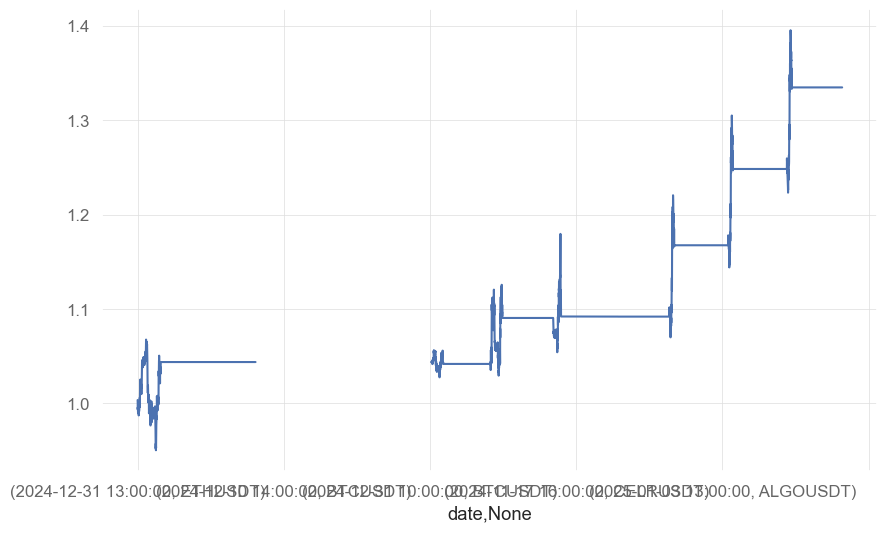

In [8]:
import matplotlib.pyplot as plt
import time

# Assuming portfolio_cumulative_returns is a pandas DataFrame or Series
plt.ion()  # Turn on interactive mode
fig, ax = plt.subplots()

portfolio_returns = pd.read_csv('strategy_returns.csv', index_col=[0, 1], parse_dates=['date'])
weights = [0, 0.5, 0.5]
portfolio_cumulative_returns = portfolio_returns.dot(weights).cumsum().apply(np.exp)
ax.clear()  # Clear the previous plot
portfolio_cumulative_returns.plot(ax=ax)  # Re-plot the data
plt.draw()  # Update the plot with new data
plt.pause(0.1)  # Pause for a short time to allow for updates
